<a href="https://colab.research.google.com/github/dvircohen0/projects/blob/main/audio_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd
import os
import glob
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.utils import  shuffle
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, precision_score, recall_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

The Processed audio features is stored at my drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
features_label = np.load('/content/drive/MyDrive/voxceleb/features_label_in.npy', allow_pickle=True)

In [25]:
features = []
labels = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0],
                                    features_label[i][1], 
                                    features_label[i][2],
                                    features_label[i][3],
                                    features_label[i][4]),
                                   axis=0))
    labels.append(features_label[i][-1])


dataset = pd.DataFrame({'features': features,
                        'labels': labels},
                       columns=['features',
                                'labels'])

# we traing only on classes we have more then 150 samples

sub_df = dataset[dataset.groupby('labels').labels.transform('count')>180].copy()

X = np.array(sub_df['features'])
for i in range(len(X)):
    X[i] = np.squeeze(X[i])
    
X=np.vstack(X)
y = np.array(sub_df['labels'])


# split to train test validation sets 

x_train, x_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=4,stratify=y)

x_val, x_test, y_val, y_test = train_test_split(
x_test, y_test, test_size=0.3, random_state=4,stratify=y_test)

In [26]:
#scaling the data

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_val = ss.transform(x_val)
x_test = ss.transform(x_test)

# oversample the data to be balanced

oversample = RandomOverSampler(sampling_strategy='minority')

x_over, y_over = oversample.fit_resample(x_train, y_train)
x_train, y_train = shuffle(x_over, y_over)

# one-hot encode the labels

lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.transform(y_val))

In [27]:
# build a simple model in keras

n_class = len(np.unique(sub_df['labels']))

model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(n_class, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=300, verbose=1, mode='auto')

In [28]:
history = model.fit(x_train, y_train, batch_size=256, epochs=1000, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop])

Epoch 1/1000
47/47 [==============================] - 1s 7ms/step - loss: 4.2212 - accuracy: 0.0241 - val_loss: 3.8095 - val_accuracy: 0.1506
Epoch 2/1000
47/47 [==============================] - 0s 5ms/step - loss: 3.8105 - accuracy: 0.0803 - val_loss: 3.1860 - val_accuracy: 0.2981
Epoch 3/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.3452 - accuracy: 0.1571 - val_loss: 2.5547 - val_accuracy: 0.3983
Epoch 4/1000
47/47 [==============================] - 0s 4ms/step - loss: 2.8570 - accuracy: 0.2497 - val_loss: 2.1440 - val_accuracy: 0.4890
Epoch 5/1000
47/47 [==============================] - 0s 4ms/step - loss: 2.5579 - accuracy: 0.3161 - val_loss: 1.9059 - val_accuracy: 0.5355
Epoch 6/1000
47/47 [==============================] - 0s 4ms/step - loss: 2.3612 - accuracy: 0.3589 - val_loss: 1.7395 - val_accuracy: 0.5695
Epoch 7/1000
47/47 [==============================] - 0s 4ms/step - loss: 2.1511 - accuracy: 0.4168 - val_loss: 1.5975 - val_accuracy: 0.5880
Epoch 

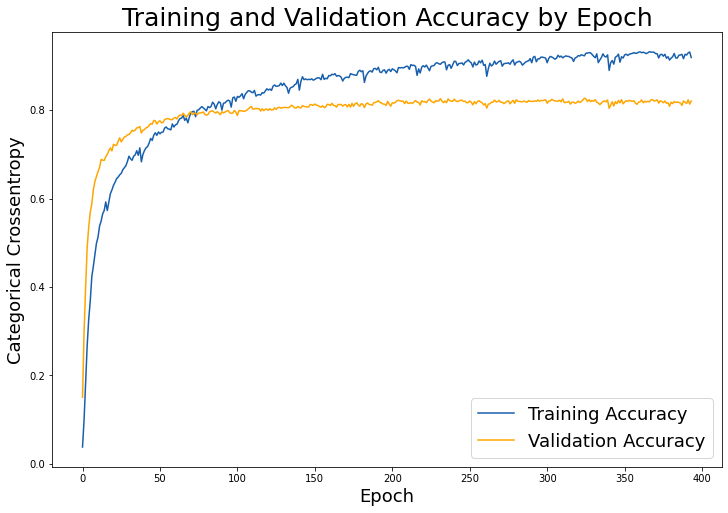

In [29]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)


plt.legend(fontsize = 18);

In [41]:
#evaluate the model

preds = model.predict_classes(x_test)
preds = lb.inverse_transform(preds)

print("accuracy score: {:.2%}".format(accuracy_score(y_test, preds)))
print("f1 score: {:.2%}".format(f1_score(y_test, preds, average="macro")))
print("precision score: {:.2%}".format(precision_score(y_test, preds, average="macro")))
print("recall score: {:.2%}".format(recall_score(y_test, preds, average="macro")))


accuracy score: 81.10%
f1 score: 80.74%
precision score: 81.64%
recall score: 80.80%


In [31]:
!pip install mlxtend --upgrade --no-deps
from mlxtend.plotting import plot_confusion_matrix

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)


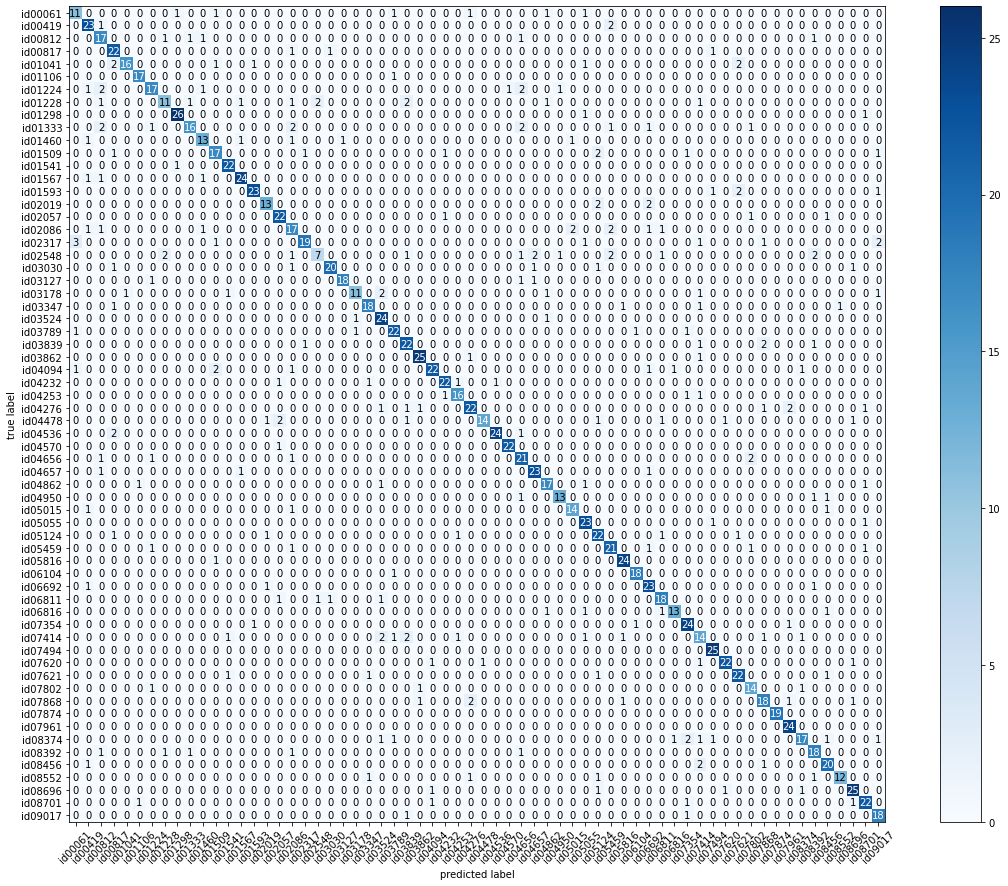

In [32]:
confusion = confusion_matrix(y_test, preds)
fig, ax = plot_confusion_matrix(conf_mat=confusion,
                               colorbar=True,
                               class_names = np.unique(y_test),
                               figsize=(20, 15))
plt.show()